# A Sketch using the new sambuca-core functionality

This is a sketch of one way to perform Sambuca parameter estimation using the sambuca-core functionality.

I prepared this notebook for two reasons: first, as a design sketch for functionality that I plan to implement in the actual sambuca package, and second as reference notes for other users of the system.

This notebook should be used with the current master branch (6/4/2016).

# Set up the environment
Nothing fancy here, just some imports and other setup code.

First, import the standard Scipy stuff, and configure matplotlib

In [1]:
%matplotlib inline
from collections import namedtuple
from pkg_resources import resource_filename
from os.path import join

import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import rasterio
from scipy.io import loadmat
from scipy.optimize import minimize
import time

#import spectral as sp
#import spectral.io.envi as envi

# set some controls on numpy formatting
# 5 decimal places, suppress scientific notation
np.set_printoptions(precision=5, suppress=True)

# set the matplotlib style to emulate ggplot2 from R
plt.style.use('ggplot')
plot_width = 12
plot_height = plot_width * 3/4

Now import the sambuca and sambuca-core packages:

In [2]:
import sambuca as sb
import sambuca_core as sbc

# Utility Functions

In [3]:
# The plot_items list is used to hold spectra for the plots
plot_items = []

In [4]:
def print_parameters(p):
    print(
'''\
    CHL:  {0:10.5f}
    CDOM: {1:10.5f}
    TR:   {2:10.5f}
    H:    {3:10.5f}
    Q:    {4:10.5f}'''
          .format(p.chl,p.cdom,p.nap,p.depth,p.substrate_fraction))

In [5]:
def show_plot():
    plt.figure(figsize=(plot_width, plot_height))
    for label, data in plot_items:
        plt.plot(data[0], data[1], label=label)
        
    plt.legend(loc='upper right')
    plt.show()

In [6]:
def add_sensor_filter_to_plot(filter_data):
    band_centre_wavelengths = filter_data[0]
    sensor_filter = filter_data[1]
    num_bands = sensor_filter.shape[0]

    for band in range(num_bands):
        band_data = sensor_filter[band, :]
        plot_items.append((
                'Filter Band {0}'.format(band),
                (band_centre_wavelengths, band_data)))

# Load the reference data

***This notebook assumes you have the bioopti_data project cloned into the same parent directory as the sambuca project.***

## Configuration

In [7]:
base_path = '/home/rya17a/projects/sambuca_project/bioopti_data/'

observed_rrs_base_path = base_path + '../sambuca/reference/wl_alos_data/inputs'
observed_rrs_raster_path = join(observed_rrs_base_path, 'WL_ALOS_R_0_sub120.img')

sensor_filter_path = join(base_path, 'sensor_filters')
sensor_filter_name = 'ALOS'

substrate_path = join(base_path, 'Substrates')
substrate1_name = 'moreton_bay_speclib:white Sand'
substrate2_name = 'moreton_bay_speclib:brown Mud'

aphy_star_path = join(base_path, 'SIOP/WL08_aphy_1nm.hdr')
aphy_star_name = 'wl08_aphy_1nm:WL08_aphy_star_mean_correct.csv:C2'

awater_path = join(base_path, 'SIOP/aw_350_900_lw2002_1nm.csv')
awater_name = 'aw_350_900_lw2002_1nm:a_water'

nedr_path = join(observed_rrs_base_path, 'WL_ALOS_NEDR_0_4bands.hdr')

## Parameters

Define the upper and lower bounds for the free parameters, using the sambuca.FreeParameters class:

In [8]:
p_min = sb.FreeParameters(
    chl=0.01,               # Concentration of chlorophyll (algal organic particulates)
    cdom=0.0005,            # Concentration of coloured dissolved organic particulates
    nap=0.2,                # Concentration of non-algal particulates
    depth=0.1,              # Water column depth
    substrate_fraction=0)   # relative proportion of substrate1 and substrate2

In [9]:
p_max = sb.FreeParameters(
    chl=0.22, 
    cdom=0.015, 
    nap=2.4,
    depth=17.4,
    substrate_fraction=1)

Create some initial parameters, one random and one as the mid point of each parameter range:

In [10]:
pmin = np.array(p_min)
pmax = np.array(p_max)
num_params = len(pmin)
p0_rand = np.random.random(num_params) * (pmax - pmin) + pmin
p0_mid = (pmax - pmin) / 2

print('p0_rand: ', p0_rand)
print('p0_mid: ', p0_mid)

p0_rand:  [ 0.10155  0.0149   1.70119  0.67508  0.80768]
p0_mid:  [ 0.105    0.00725  1.1      8.65     0.5    ]


In [11]:
# repackage p_min and p_max into the tuple of (min,max) pairs expected by our objective function,
# and by the minimisation methods that support bounds
p_bounds = tuple(zip(p_min, p_max))
print('p_bounds', p_bounds)

p_bounds ((0.01, 0.22), (0.0005, 0.015), (0.2, 2.4), (0.1, 17.4), (0, 1))


## Observed Reflectance

### Load the ENVI raster with the rasterio library
And store some basic metadata...

In [12]:
observed_rrs_width = 0
observed_rrs_height = 0
observed_rrs = None

with rasterio.drivers():
    with rasterio.open(observed_rrs_raster_path) as src:
        print('Observed rrs file: ', observed_rrs_raster_path)
        print('Width, height: ', src.width, src.height)
        print('crs: ', src.crs)
        print('affine: ', src.affine)
        print('num bands: ', src.count)
        print('band indicies: ', src.indexes)
        
        observed_rrs_width = src.width
        observed_rrs_height = src.height
        observed_rrs = src.read()

Observed rrs file:  /home/rya17a/projects/sambuca_project/bioopti_data/../sambuca/reference/wl_alos_data/inputs/WL_ALOS_R_0_sub120.img
Width, height:  120 120
crs:  {'init': 'epsg:32756'}
affine:  | 10.00, 0.00, 452754.14|
| 0.00,-10.00, 6431592.57|
| 0.00, 0.00, 1.00|
num bands:  4
band indicies:  [1, 2, 3, 4]


## Load SIOPs and other data using the sambuca-core functions

### Load the sensor filter:

In [13]:
# load all filters from the given directory
sensor_filters = sbc.load_sensor_filters(sensor_filter_path)

# We don't need to do this, but it lets us see the name of all loaded filters
sensor_filters.keys()

dict_keys(['QB', 'PHILLS', 'LS8b', 'WV2', 'LDCM', 'LS8', 'WV27B', 'LS8QB', 'LS7b', 'LS7c', 'LS7', 'LS5b', 'LS5', 'CASI04', 'LS8w', 'Hymap06', 'ALOS'])

In [14]:
# retrieve the specified filter
sensor_filter = sensor_filters[sensor_filter_name]

 Plot the sensor filter:

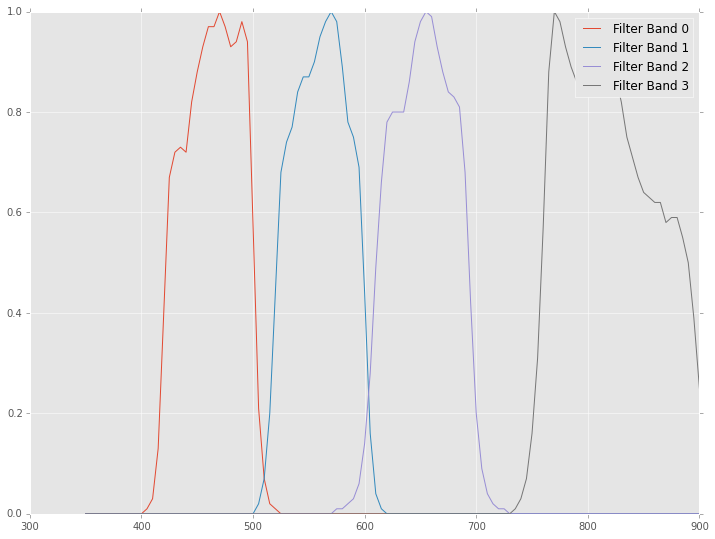

In [15]:
plot_items.clear()
add_sensor_filter_to_plot(sensor_filter)
show_plot()

### Load the substrates
This example uses the load_all_spectral_libraries function to return a dictionary of everything found in a directory. We then retrieve the required substrates from the dictionary.

In [16]:
all_substrates = sbc.load_all_spectral_libraries(substrate_path)
substrate1 = all_substrates[substrate1_name]
substrate2 = all_substrates[substrate2_name]

Note that the sambuca_core spectral library loading functions return a dictionary of (band-centre wavelength, value) tuples. Thus substrate1 and substrate2 are tuples.

### Aphystar
Here we load a single file, although we could have used the load_all_spectral_libraries approach with the same result.

Note that although we specify a single file, a dictionary is still returned. This is for two reasons: consistency with the other functions, and because a single file may contain multiple spectra (depending on the format).

In [17]:
aphy_star = sbc.load_spectral_library(aphy_star_path)[aphy_star_name]

### Awater

In [18]:
awater = sbc.load_spectral_library(awater_path)[awater_name]

### NEDR

In [19]:
nedr = sbc.load_spectral_library(nedr_path, validate=False)['wl_alos_nedr_0_4bands:33']
nedr

(array([ 460.,  560.,  650.,  825.]),
 array([ 0.00336,  0.00252,  0.00232,  0.00319]))

### Plot the SIOPS, just because we can :)

Leave awater out of the first plot, because the scale obscures other values

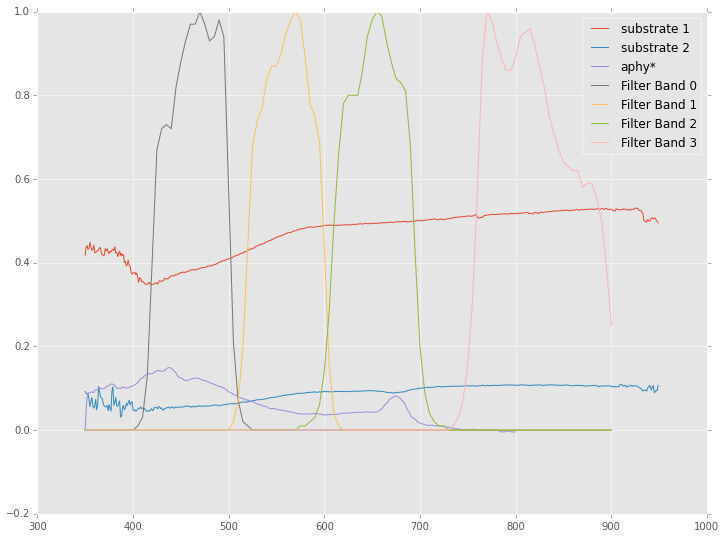

In [20]:
plot_items.clear()
plot_items.append(('substrate 1', substrate1))
plot_items.append(('substrate 2', substrate2))
plot_items.append(('aphy*', aphy_star))
add_sensor_filter_to_plot(sensor_filter)
show_plot()

Second plot, with awater

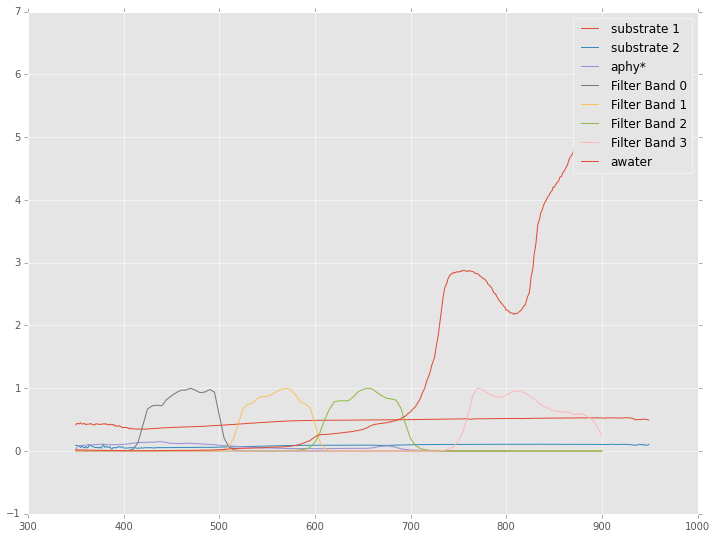

In [21]:
plot_items.append(('awater', awater))
show_plot()

## Find the Common Wavelengths Subset

In [22]:
print('awater: min: {0}  max: {1}'.format(min(awater[0]), max(awater[0])))
print('aphy_star: min: {0}  max: {1}'.format(min(aphy_star[0]), max(aphy_star[0])))
print('substrate1: min: {0}  max: {1}'.format(min(substrate1[0]), max(substrate1[0])))
print('substrate2: min: {0}  max: {1}'.format(min(substrate2[0]), max(substrate2[0])))

awater: min: 350  max: 900
aphy_star: min: 350.0  max: 800.0
substrate1: min: 350  max: 949
substrate2: min: 350  max: 949


In [23]:
wavelengths = sbc.spectra_find_common_wavelengths(awater, aphy_star, substrate1, substrate2)
print('Common wavelength range: {0} - {1}'.format(min(wavelengths), max(wavelengths)))

Common wavelength range: 350.0 - 800.0


Use the common wavelengths to mask the inputs:

In [24]:
awater = sbc.spectra_apply_wavelength_mask(awater, wavelengths)
aphy_star = sbc.spectra_apply_wavelength_mask(aphy_star, wavelengths)
substrate1 = sbc.spectra_apply_wavelength_mask(substrate1, wavelengths)
substrate2 = sbc.spectra_apply_wavelength_mask(substrate2, wavelengths)
    
print('awater: min: {0}  max: {1}'.format(min(awater[0]), max(awater[0])))
print('aphy_star: min: {0}  max: {1}'.format(min(aphy_star[0]), max(aphy_star[0])))
print('substrate1: min: {0}  max: {1}'.format(min(substrate1[0]), max(substrate1[0])))
print('substrate2: min: {0}  max: {1}'.format(min(substrate2[0]), max(substrate2[0])))

awater: min: 350  max: 800
aphy_star: min: 350.0  max: 800.0
substrate1: min: 350  max: 800
substrate2: min: 350  max: 800


## Truncate the sensor filter to match the common wavelength range
It remains to be seen whether this is the best approach, but it works for this demo.
An alternative approach would be to truncate the entire band for any band that falls outside the common wavelength range.

**If this approach, or something based on it, is valid, then this should be moved into a sambuca_core function with appropriate unit tests.**

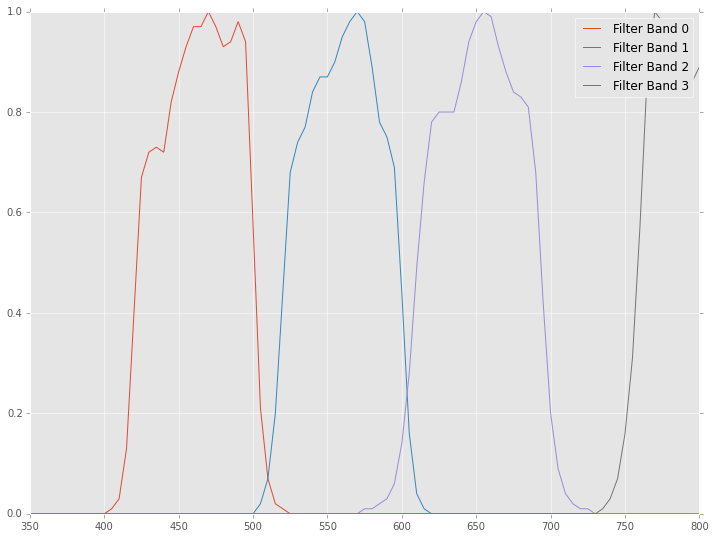

In [25]:
filter_mask = (sensor_filter[0] >= wavelengths.min()) & (sensor_filter[0] <= wavelengths.max())
sensor_filter = sensor_filter[0][filter_mask], sensor_filter[1][:,filter_mask]
plot_items.clear()
add_sensor_filter_to_plot(sensor_filter)
show_plot()

## Build the fixed parameters structure
For this demo, we use the default values for every all parameters not specified below. See the API documentation for the remaining parameters and their default values.

In [26]:
fixed_parameters = sb.create_fixed_parameter_set(
    wavelengths=wavelengths,
    a_water=awater,
    a_ph_star=aphy_star,
    substrate1=substrate1,
    substrate2=substrate2,
    )

# Spatial run with single substrate pair

**The outline of the algorithm here is**:
- Load the input data
- Load the observed rrs raster with rasterio
- Set the parameter bounds and initial values
- Create the objective function object
- Create a pixel result handler that does something with the pixel results from the parameter estimator
- run the parameter estimator on the pixel range
- Do something with the results. In this notebook we simply plot a few of them, but they could be saved to files or passed via messages to the coordinator process in a parallel run.

## A note on parallelism

This notebook is deliberately using serial code. It is intended as a documented version of my working notes on Sambuca, for use by future authors in completing the system.

I think that a course-grained parallelism approach will work well for Sambuca, with the decomposition based on spatial tiling of the total problem area. A suggested outline is:
- Spatial decomposition splits the input region into a user defined number of spatial tiles
    - This need not require the generation of new files. It might be sufficient to generate a list of regions (eg: pixel bounds (xmin=100, xmax=200, ymin=3000, ymax=3100)) that will tell each sambuca process the data subset it should operate on.
- A separate serial Sambuca process is executed on each tile
    - depending on the implementation method, the results could then be written out to separate files encoded with the tile index, or they could be passed in memory back to the main process for the composition stage (eg: an MPI-like approach).
- When all Sambuca runs are complete, a spatial composition stage joins the tiled outputs into a final set of spatial outputs.

Python parallel processing approaches that look promising are:
### IPython Parallel
- Master python code does these tasks
    - set up problem (input spectra, parameter bounds, etc)
    - defines (probably from user configuration)
        - required output products
    - initialise the IPython parallel framework (ipcluster, engines etc)
    - spatial decomposition into tiles, with each tile being processed by a single engine
        - each engine will be doing serial processing over its allocated spatial region in much the same way as the code in this notebook.
    - recompose the results from each engine into the final set of outputs
- It remains to be seen if the best performance will be achieved by:
    - having each parallel task generate a full set of results by feeding the estimated parameters back into the Sambuca model, or
    - simply returning the estimated parameters (or a null-result for pixels that fail to converge) to the master code. These parameters could then be used to generate the rest of the outputs.

The first approach reduces the amount of parallelism, but also reduces the amount of data being passed as messages. I suspect the second approach will be preferable.
   
### Rasterio & rio-mucho  
The rio-mucho library promises parallel processing of spatial data by providing a parallel spatial tiling system on top of rasterio.
- This is worth investigation.
- However, the current documentation suggests that rio-mucho only handles writing to a single output raster. If so, this would require all Sambuca outputs being written into one raster. Depending on the required outputs, this could easily generate a raster with dozens of bands, many of which don't really belong together.
    - If this approach gives good performance, then post-processing could be used to split the *uber-raster* into separate files.        

# Define the spatial region

For the sake of simplicity, I am just defining a simple rectangle of pixel coordinates. In the final application this will could be something like:
- An entire raster with the number of tiles specified, or
- A spatial polygon along with the number of tiles to decompose into

In [27]:
xstart = 0
xend = 120
xspan = xend - xstart
ystart = 0
yend = 120
num_pixels = xspan * (yend - ystart)

assert xend <= observed_rrs_width
assert yend <= observed_rrs_height

print('Pixel count: ', num_pixels)

Pixel count:  14400


# Do the run

## Create some IPython widgets for progress reporting

In [28]:
from IPython.display import clear_output, display
from ipywidgets import IntProgress, Text

progress_bar = IntProgress()
text_widget = Text()
skip_count_widget = Text()
percentage_widget = Text()

## Create the objective calculator

In [29]:
objective = sb.SciPyObjective(sensor_filter, fixed_parameters, error_function=sb.distance_f, nedr=nedr)

## Create the pixel result handler for capturing per-pixel outputs

In [30]:
result_recorder = sb.ArrayResultWriter(
    observed_rrs_width,
    observed_rrs_height,
    sensor_filter,  
    nedr,
    fixed_parameters)

Note this example skips over some extra spatial details that should be addressed:
- Getting the invalid pixels mask from rasterio, so that we don't try to process pixels with no data
- This example takes about 772sec (~54ms per minimize call)


In [31]:
display(text_widget)
display(skip_count_widget)
display(percentage_widget)
display(progress_bar)

# reset the widgets
n = 0
skip_count = 0
progress_bar.value = 0
progress_bar.max = num_pixels
skip_count_widget.value = ""
text_widget.value = 'x: {0}  y: {1}  n: {2}'.format(0, 0, n)
percentage_widget.value = 'Percentage complete: {0}%'.format(int(100*n/(num_pixels)))

p0 = p0_mid

t0 = time.time()
for x in range(xstart, xend):
    for y in range(ystart, yend):
        obs_rrs = observed_rrs[:,x,y]
        
        # Quick and dirty check because we are not masking out the no-data pixels
        if not np.allclose(obs_rrs, 0):
            
            # we need to set the observed rrs for this pixel into the objective, as there is no
            # direct way to get the scipy.minimise function to do it (although there are other ways
            # such as using a closure)
            objective.observed_rrs = obs_rrs

            result = minimize(
                        objective, 
                        p0, 
                        method='SLSQP', 
                        bounds=p_bounds, 
                        options={'disp':False, 'maxiter':500})

            #%time result = minimize(objective, p0, method='SLSQP', bounds=p_bounds, options={'disp':False, 'maxiter':500})

            # todo: check if the minimiser converged!
            
            # we need to repack the parameter tuple used by scipy.minimize into the sambuca.FreeParameter tuple
            # expected by the pixel result handlers. As the p0 tuple was generated from a FreeParameter tuple in the 
            # first place, we know that the order of the values match, so we can simply unpack the result tuple into 
            # the FreeParameters constructor.
            #print(result.nit,result.success,*result['x'])
            result_recorder(x, y, obs_rrs, parameters=sb.FreeParameters(*result['x']), nit=result.nit, success=result.success)
            #result_recorder(x, y, obs_rrs, parameters=sb.FreeParameters(*result['x']))
        else:
            skip_count += 1
            skip_count_widget.value = 'Pixels skipped (bad input spectra): {0}'.format(skip_count)
        
        # update the progress bar
        n += 1
        text_widget.value = 'x: {0}  y: {1}  n: {2}'.format(x, y, n)
        percentage_widget.value = 'Percentage complete: {0}%'.format(int(100*n/(num_pixels)))
        progress_bar.value = n


t1 = time.time()
print("Total execution time: {0:.1f} seconds".format(t1-t0))
print("Average time per pixel: {0:.3f} seconds".format((t1-t0)/n))

Total execution time: 772.2 seconds
Average time per pixel: 0.054 seconds


# Visualise some of the results

### We should check that the results are within the bounds:

By comparing the min/max to the bounds of each free parameter, some of the returned results are violating this condition.  It seems these errors are small and it may be ok to accept these results if rounded to a suitable precision.  I don't know this!

In [32]:
skip_mask = (result_recorder.success < 1)

In [33]:
#chl = ma.masked_array(result_recorder.chl,mask=skip_mask | (np.isnan(result_recorder.chl)))
chl = ma.masked_array(result_recorder.chl,mask=skip_mask)

print("Minimum bound of chl is {0}, minimum is {1}".format(pmin[0],chl.min()))
print("Maximum bound of chl is {0}, maximum is {1}".format(pmax[0],chl.max()))

Minimum bound of chl is 0.01, minimum is 0.008858164784529153
Maximum bound of chl is 0.22, maximum is 0.22000927898809358


In [34]:
#cdom = ma.masked_array(result_recorder.cdom,mask=skip_mask | (np.isnan(result_recorder.cdom)))
cdom = ma.masked_array(result_recorder.cdom,mask=skip_mask)

print("Minimum bound of cdom is {0}, minimum is {1}".format(pmin[1],cdom.min()))
print("Maximum bound of cdom is {0}, maximum is {1}".format(pmax[1],cdom.max()))

Minimum bound of cdom is 0.0005, minimum is 0.0004919687689668107
Maximum bound of cdom is 0.015, maximum is 0.01500000172904116


In [35]:
#nap = ma.masked_array(result_recorder.nap,mask=skip_mask | (np.isnan(result_recorder.nap)))
nap = ma.masked_array(result_recorder.nap,mask=skip_mask)

print("Minimum bound of nap is {0}, minimum is {1}".format(pmin[2],nap.min()))
print("Maximum bound of nap is {0}, maximum is {1}".format(pmax[2],nap.max()))

Minimum bound of nap is 0.2, minimum is 0.19977069555625723
Maximum bound of nap is 2.4, maximum is 2.400121158545333


In [36]:
#depth = ma.masked_array(result_recorder.depth,mask=skip_mask | (np.isnan(result_recorder.depth)))
depth = ma.masked_array(result_recorder.depth,mask=skip_mask)

print("Minimum bound of depth is {0}, minimum is {1}".format(pmin[3],depth.min()))
print("Maximum bound of depth is {0}, maximum is {1}".format(pmax[3],depth.max()))

Minimum bound of depth is 0.1, minimum is 0.09359863146723932
Maximum bound of depth is 17.4, maximum is 8.821485455947373


In [37]:
#substrate_fraction = ma.masked_array(result_recorder.substrate_fraction,mask=skip_mask | (np.isnan(result_recorder.substrate_fraction)))
substrate_fraction = ma.masked_array(result_recorder.substrate_fraction,mask=skip_mask)

print("Minimum bound of substrate_fraction is {0}, minimum is {1}".format(pmin[4],substrate_fraction.min()))
print("Maximum bound of substrate_fraction is {0}, maximum is {1}".format(pmax[4],substrate_fraction.max()))

Minimum bound of substrate_fraction is 0.0, minimum is -1.0980105713496714e-13
Maximum bound of substrate_fraction is 1.0, maximum is 1.0000017170314162


### Check results at a random location:

In [38]:
x = 63
y = 70

print('chl:', result_recorder.chl[x,y])
print('cdom:', result_recorder.cdom[x,y])
print('nap:', result_recorder.nap[x,y])
print('depth:', result_recorder.depth[x,y])
print('substrate_fraction:', result_recorder.substrate_fraction[x,y])
print('nit:', result_recorder.nit[x,y])
print('success:', result_recorder.success[x,y])

chl: 0.01
cdom: 0.00584405236344
nap: 2.4
depth: 8.5920097209
substrate_fraction: 1.0
nit: 7.0
success: 1.0


### Plot the number of iterations to complete the minimzation:

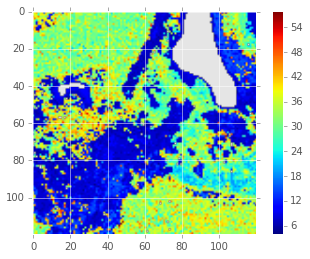

In [39]:
nit = ma.masked_array(result_recorder.nit,mask=skip_mask)
plt.imshow(nit[xstart:xend,ystart:yend]);
img = plt.colorbar()

### Lets put the number of iterations into bins to see the distribution:

In [40]:
u, inv = np.unique(result_recorder.nit[xstart:xend,ystart:yend], return_inverse=True)
n = np.bincount(inv)
print("bins: ",u)
print("count: ",n)

bins:  [  -1.    4.    5.    6.    7.    8.    9.   10.   11.   12.   13.   14.
   15.   16.   17.   18.   19.   20.   21.   22.   23.   24.   25.   26.
   27.   28.   29.   30.   31.   32.   33.   34.   35.   36.   37.   38.
   39.   40.   41.   42.   43.   44.   45.   46.   47.   48.   49.   50.
   51.   52.   53.   55.   56.   57.   58.  501.]
count:  [ 933    3   53  280  864 1734  750  404  166  217  263  261  187   64   17
   12   36   46   89   90  137  220  243  254  371  416  419  494  586  490
  500  486  469  377  460  427  276  313  216  200  159  113   71   64   59
   33   23   18    9    4    2    1    2    2    3   14]


### Better yet, lets plot a histogram to see the distriubtion:

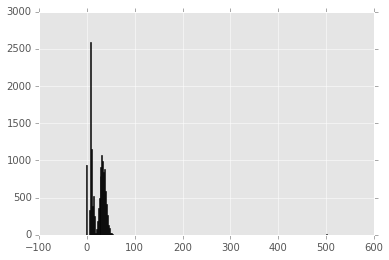

In [41]:
img = plt.hist(result_recorder.nit[xstart:xend,ystart:yend].flatten(), bins=256, fc='k', ec='k')

The iteration count is a proxy for the ammount of work per pixel, as the distribution is not equal this has consequences regarding load balancing when this workflow is parallelized.
Focusing on the area excluding the largest iteration count we can see the distribution more clearly.

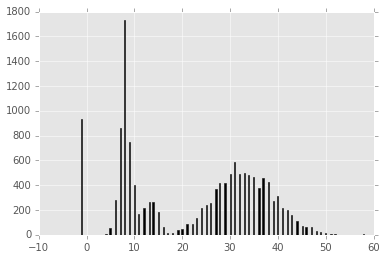

In [42]:
img = plt.hist(result_recorder.nit[xstart:xend,ystart:yend].flatten(), bins=256, fc='k', ec='k', range=[-10,60])

### Plot the success of the minimzation for each pixel:

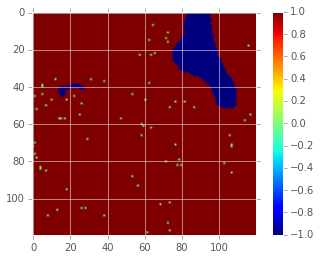

In [43]:
plt.imshow(result_recorder.success[xstart:xend,ystart:yend]);
img = plt.colorbar()

You can see the majority of pixels returned 1 (dark red/brown) for a successfully minimzation.  Those coloured dark blue where skipped.  It can be seen that there are some points (light green) that returned 0, indicating the minimzation failed.
The plot below shows a close up of one of the areas that shows failures.

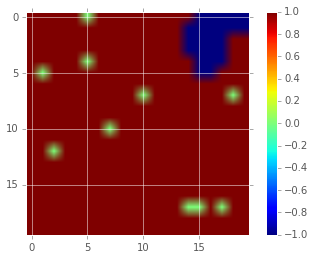

In [44]:
plt.imshow(result_recorder.success[40:60,0:20], vmin=-1);
img = plt.colorbar()

### We can count the number of (or not) successfull minimzations by placing them in bins:

In [45]:
u, inv = np.unique(result_recorder.success[xstart:xend,ystart:yend], return_inverse=True)
n = np.bincount(inv)
print("bins: ",u)
print("count: ",n)

bins:  [-1.  0.  1.]
count:  [  933    71 13396]


Here 933 pixels where skipped, 71 pixels failed, and the bulk of 13396 where successfull.

## Lets plot the results for the free parameters:

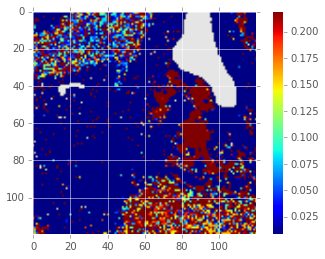

In [46]:
plt.imshow(chl[xstart:xend,ystart:yend]);
img = plt.colorbar()

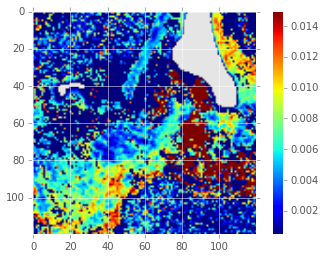

In [47]:
plt.imshow(cdom[xstart:xend,ystart:yend]);
img = plt.colorbar()

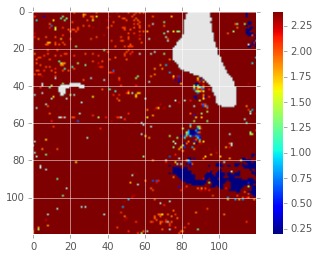

In [48]:
plt.imshow(nap[xstart:xend,ystart:yend]);
img = plt.colorbar()

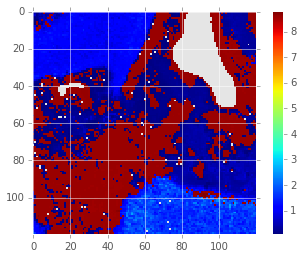

In [49]:
plt.imshow(depth[xstart:xend,ystart:yend], interpolation='nearest');
img = plt.colorbar()

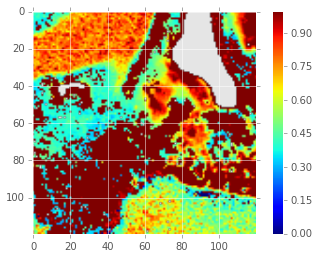

In [50]:
plt.imshow(substrate_fraction[xstart:xend,ystart:yend]);
img = plt.colorbar()

## And some more plots:

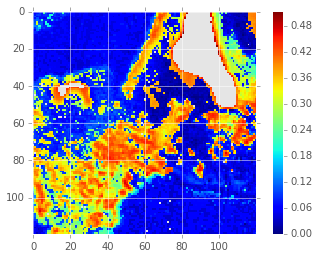

In [51]:
error_f = ma.masked_array(result_recorder.error_f,mask=skip_mask)
plt.imshow(error_f[xstart:xend,ystart:yend], interpolation='nearest');
img = plt.colorbar()

I don't have time to sort out plotting the 4 band closed_rrs in pseudo-colour, so I will just plot the 4 bands separately. It can be done, and is probably not hard...

One approach would be to create a multi-band raster from the separate channel arrays using rasterio, and then use cartopy to render a nice map to a matplotlib plot. EG: http://snorf.net/blog/2014/06/26/using-cartopy-with-rasterio/

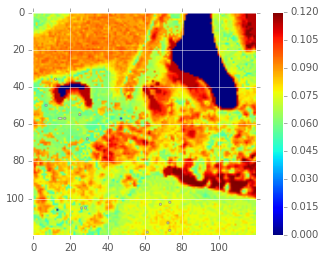

In [52]:
plt.imshow(result_recorder.closed_rrs[0,xstart:xend,ystart:yend]);
img = plt.colorbar()

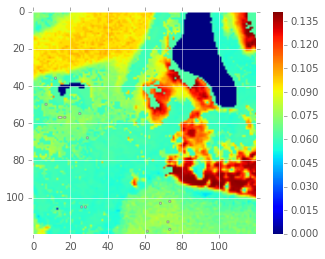

In [53]:
plt.imshow(result_recorder.closed_rrs[1,xstart:xend,ystart:yend]);
img = plt.colorbar()

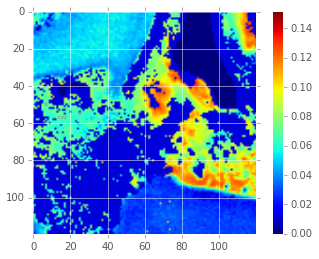

In [54]:
plt.imshow(result_recorder.closed_rrs[2,xstart:xend,ystart:yend]);
img = plt.colorbar()

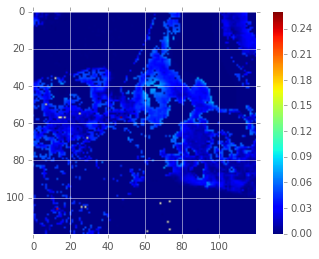

In [55]:
plt.imshow(result_recorder.closed_rrs[3,xstart:xend,ystart:yend]);
img = plt.colorbar()